In [3]:
import sys
sys.path.append("/home/ubuntu/fastai/")

In [4]:
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from glob import glob
import pandas as pd
import helper
from tqdm import tqdm
import hashlib
from urllib import request


In [32]:
%matplotlib inline


In [50]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
%reload_ext autoreload

In [31]:
PATH = "data/processed/"


In [108]:
!ls data

labels.csv.zip	sample_submission.csv.zip  train      valid
processed	test.zip		   train.zip


In [109]:
?ImageClassifierData.from_paths

In [7]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,
                           max_zoom=1.1)
    data = ImageClassifierData.from_paths(path='data'
            , num_workers=8
            , tfms=tfms, bs=bs)
    #return data.resize(sz, 'tmp')
    return data if sz>300 else data.resize(340, 'tmp')

In [8]:
sz = 224 # size of image
arch = resnet50 #model architecture.. model has 101 layers
bs=128 # batch size; number of images to process at one time

In [15]:
??ConvLearner.pretrained

In [12]:
??learn.fit

In [5]:
?ConvLearner.pretrained

In [9]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lrs=1e-2, n_cycle=3)

                                                    
100%|██████████| 67/67 [01:11<00:00,  1.06s/it]


epoch      trn_loss   val_loss   accuracy                 
    0      2.116328   0.839613   0.837573  
    1      1.102709   0.572471   0.86546                  
    2      0.727348   0.484909   0.863503                  



[array([0.48491]), 0.8635029363538888]

** Train with data augmentation **

In [130]:
learn.precompute = False
learn.fit(lrs=1e-2, n_cycle=5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.209922   1.157682   0.789628  
    1      1.147099   1.045192   0.800881                 
    2      1.079587   0.950806   0.808708                 
    3      1.011394   0.874144   0.829746                 
    4      0.948125   0.820159   0.840509                  


[array([0.82016]), 0.8405088053290858]

** Train more with layer unfreezing **

In [132]:
learn.unfreeze()

In [133]:
lr=1e-2
lr=np.array([lr/18,lr/6,lr/2])

In [134]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy                  
    0      0.985945   0.844976   0.816536  
    1      0.896815   0.759135   0.828767                  
    2      0.805439   0.761015   0.836595                  
    3      0.744344   0.704036   0.842955                  
    4      0.677747   0.675216   0.84589                   
    5      0.614678   0.664459   0.84638                   
    6      0.568571   0.659542   0.846869                  


[array([0.65954]), 0.8468688840735449]

** calculate accuracy with test time augmentation **

In [140]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0)
(metrics.log_loss(y,preds), accuracy_np(preds,y))

(0.6672114708747691, 0.8590998043052838)

In [141]:
predicted_class = np.argmax(preds, axis=1)
confidence = np.max(preds, axis=1)

In [142]:
predictions_df = pd.DataFrame ({'actual': y, 'pred': predicted_class,'image':learn.data.val_ds.fnames,'conf':confidence})

In [143]:
predictions_df['actual_class'] = predictions_df['actual'].apply(lambda x : data.classes[x])
predictions_df['pred_class'] = predictions_df['pred'].apply(lambda x : data.classes[x])

In [144]:
predictions_df.head()


,actual,pred,image,conf,actual_class,pred_class
0,0,0,valid/affenpinscher/83f0bb565b2186dbcc6a9d009c...,0.966812,affenpinscher,affenpinscher
1,0,0,valid/affenpinscher/e3eb50726f2104cbf86db02d44...,0.580092,affenpinscher,affenpinscher
2,0,0,valid/affenpinscher/106d7e0df869e7ba9f6d16c5f7...,0.961599,affenpinscher,affenpinscher
3,0,0,valid/affenpinscher/1ee0c041d15647e3909625eba4...,0.929607,affenpinscher,affenpinscher
4,0,0,valid/affenpinscher/91a5e8db15bccfb6cfa2df5e8b...,0.530063,affenpinscher,affenpinscher


In [189]:
def predict_class(image_path):
    trn_tfms, val_tfms = tfms_from_model(arch, sz)
    im = val_tfms(np.array(open_image(image_path)))

    preds = learn.predict_array(im[None])
    class_idx = np.argmax(preds)
    print(data.classes[class_idx],np.max(preds))
    
    img = PIL.Image.open(image_path);
    #return img
    
    return helper.get_top_n_predictions(np.exp(preds), data.classes)
    #return np.argmax(preds)

def predict_class_web(url,ext="jpg"):
    url_hash = hashlib.md5(url.encode('utf-8')).hexdigest()
    file_name = f'data/downloaded/{url_hash}.{ext}'
    f = open(file_name, 'wb')
    f.write(request.urlopen(url).read())
    f.close()
    
    return predict_class(file_name)

In [159]:
!mkdir -p data/downloaded

In [192]:
predict_class_web("https://vetstreet.brightspotcdn.com/dims4/default/3407f3b/2147483647/thumbnail/645x380/quality/90/?url=https%3A%2F%2Fvetstreet-brightspot.s3.amazonaws.com%2Ffb%2F31%2F032a6aae436a9821acda211044fb%2Fbulldog-ap-rn4myi-645.jpg")

boxer -0.70219517


[('boxer', 0.49549642),
 ('bull_mastiff', 0.14114214),
 ('french_bulldog', 0.06522579),
 ('boston_bull', 0.048814207),
 ('pug', 0.03918686)]

In [183]:
len(preds.shape)

2

** Confusion Matrix**

In [195]:
labels = learn.data.classes
cm = confusion_matrix(predictions_df['actual'], predictions_df['pred'])

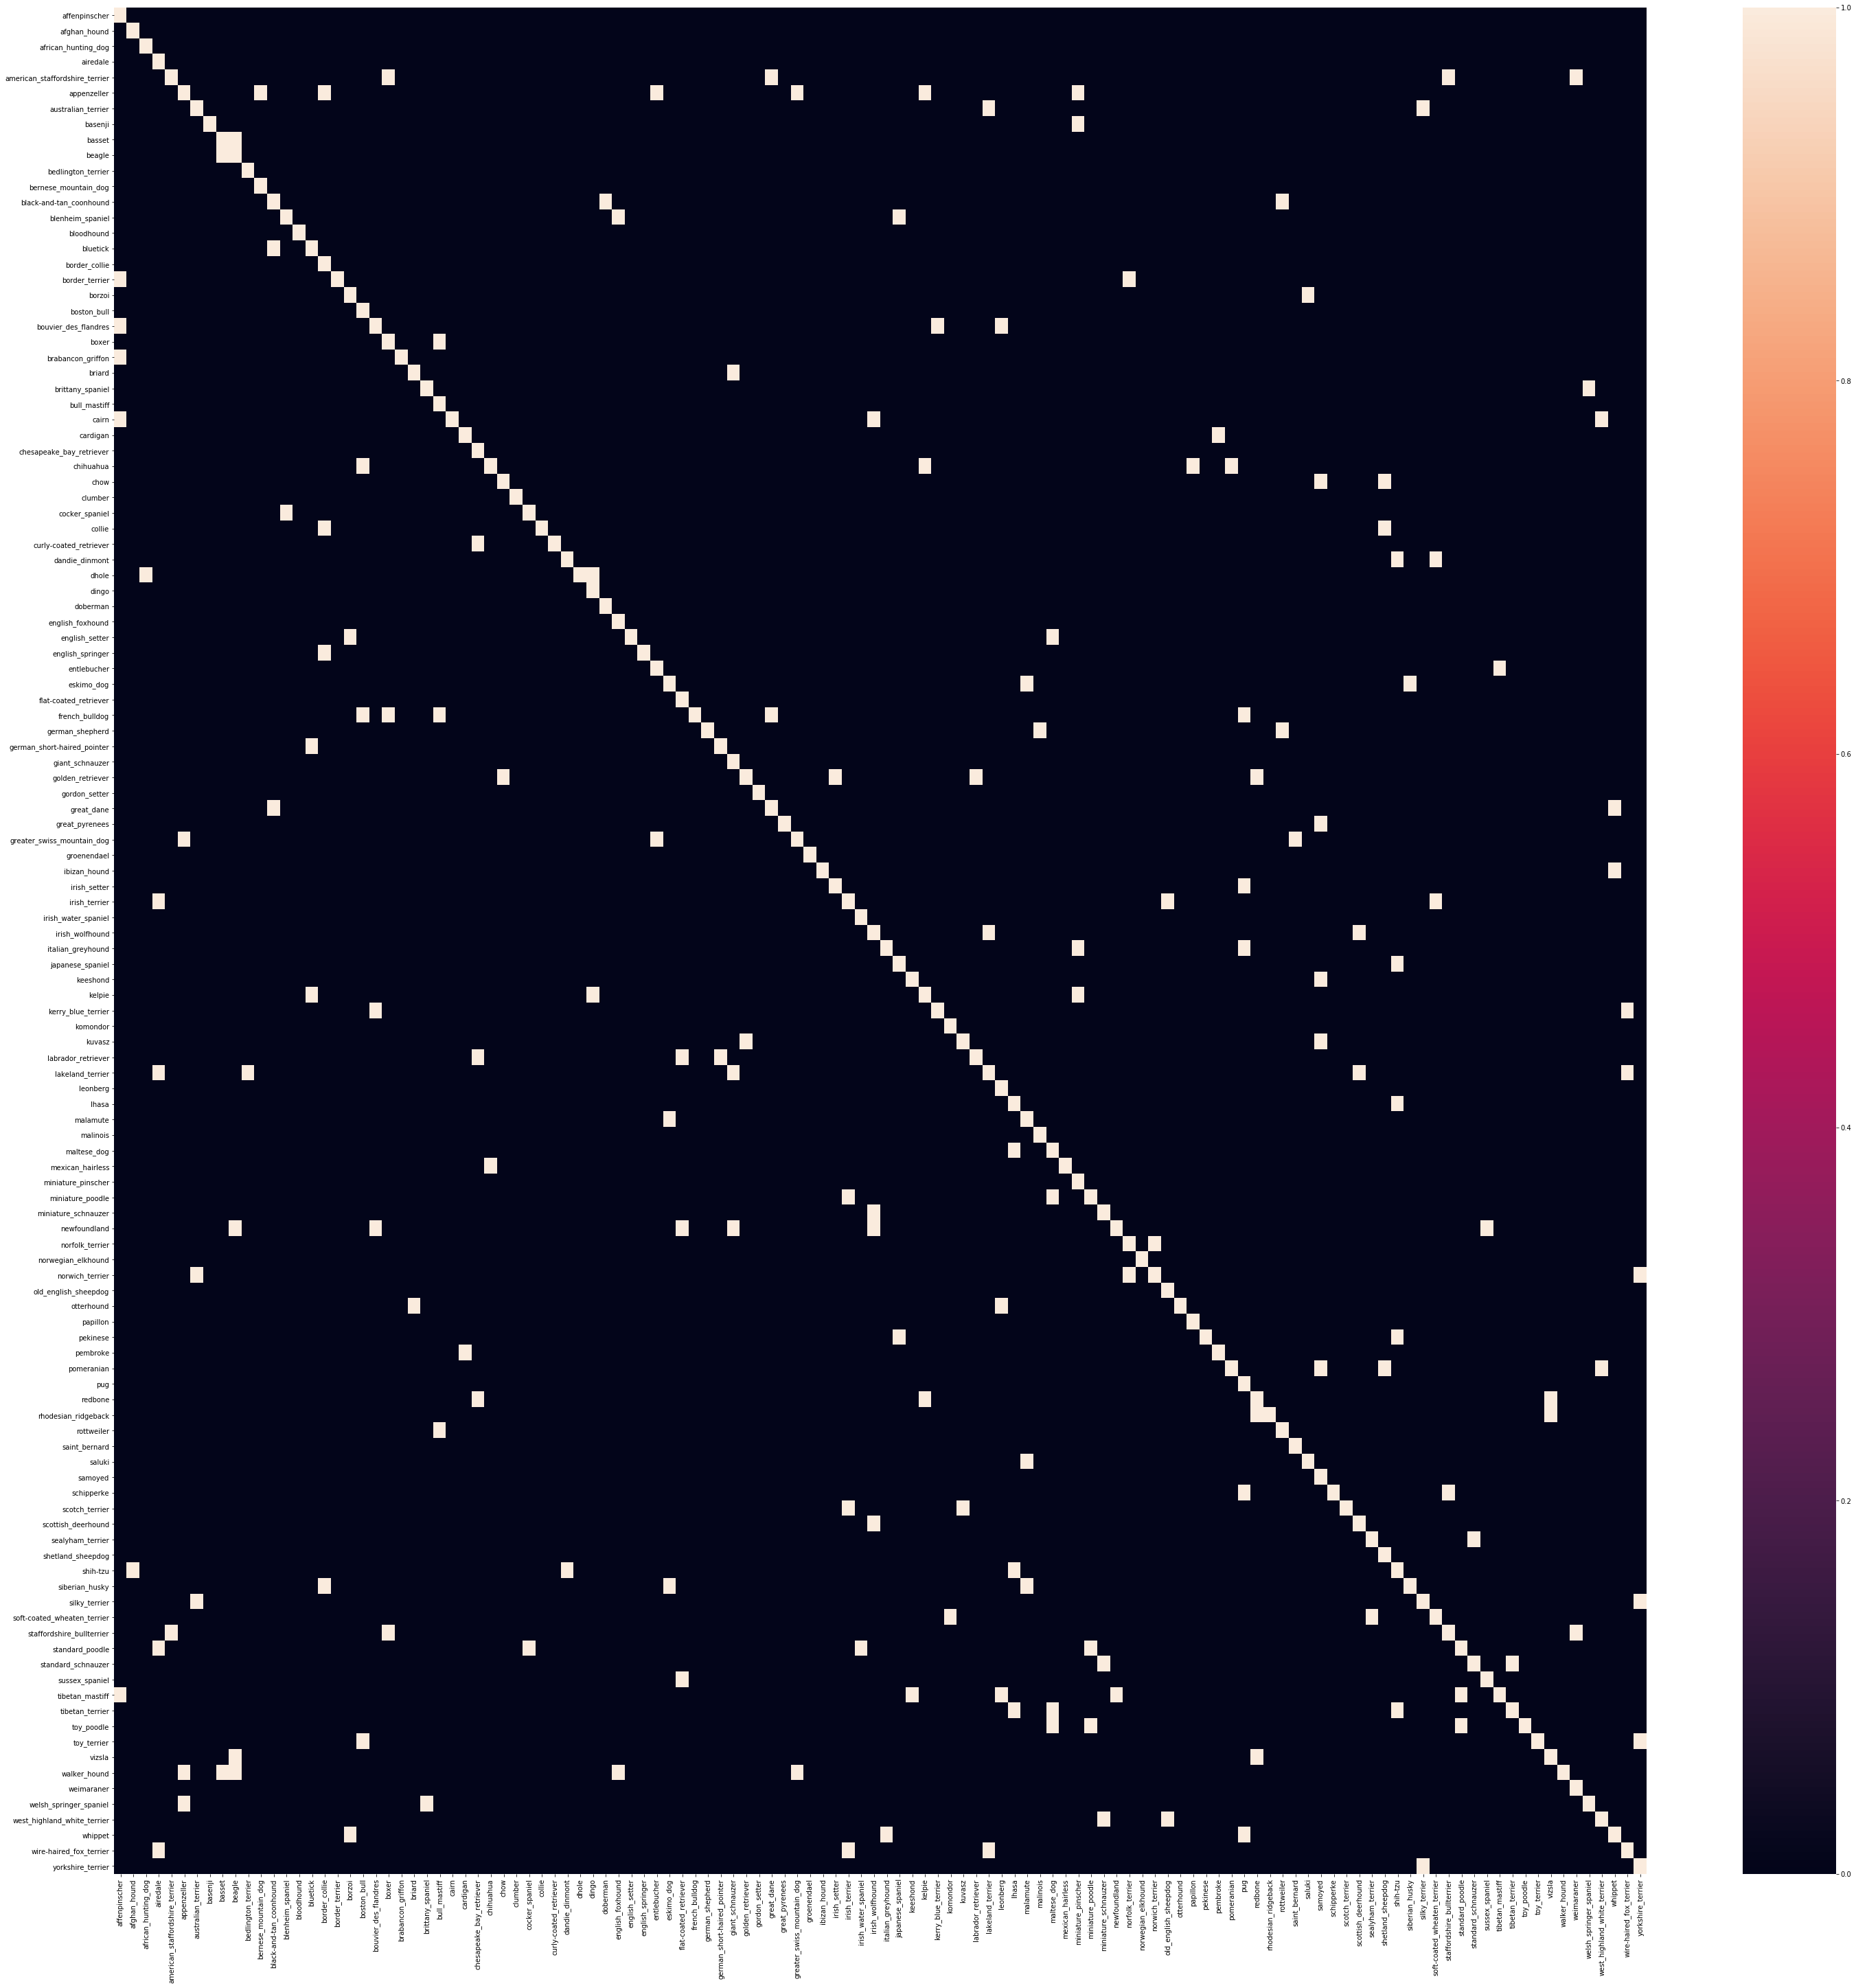

In [197]:
fig, ax = plt.subplots(figsize=(50, 50))
_ = sns.heatmap(cm, ax=ax, yticklabels=labels, xticklabels=labels, robust=True)

In [198]:
fastai.model.model_urls

{'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
 'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
 'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
 'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'}